In [1]:
import sys

sys.path.append("../")

import thermonets as tn
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pyatmos
import cartopy.crs as ccrs
from tqdm import tqdm

The EOP file 'finals2000A.all' in /Users/dario.izzo/src/iers/ is already the latest.
The Leap Second file 'Leap_Second.dat' in /Users/dario.izzo/src/iers/ is already the latest.


### 1 - Load the dataset
The dataset of atmospheric values for the requested ranges of altitudes can be created running `scripts/generate_jb08_db.py`, and is here loaded.

In [2]:
# Here we the db the model was trained upon.
# note that columns are (len 22):
# day, month, year, hour, minute, second, microsecond, alt [km], lat [deg], lon [deg], sun ra [deg], sun dec [deg], f107, f107A, s107, s107A, m107, m107A, y107, y107A, dDstdT, density [kg/m^3]
db = np.loadtxt("../dbs/jb08_db.txt", delimiter=",", skiprows=1)
np.random.shuffle(db)

print(f"Shape of database is: {db.shape}")

Shape of database is: (1000000, 22)


### 2 - Perform model inference
The `JB-08` neural model trained in `/notebooks/jb-08.py` is hardcoded into the thermonets module (upon import it get loaded) and here used to reproduce the various atmospheric values in the database it was trained upon.

NOTE: The following cell will take ~1 minute-ish and could be easily parallelized using vectorization across the various inputs, unfortunately the API we forced upon ``jb08_tn`` is not allowing the requested vecorization (only h, lat, lon), hence the slowdown.

In [3]:
from tqdm import tqdm

# we extract the target density:
true = db[:, -1]
# and now we do inference and extract the predicted one:
predicted = []
for item in tqdm(db):
    date = datetime.datetime(
        year=int(item[2]),
        month=int(item[1]),
        day=int(item[0]),
        hour=int(item[3]),
        minute=int(item[4]),
        second=int(item[5]),
        microsecond=int(item[6]),
    )
    doy = date.timetuple().tm_yday
    sid = item[3] * 3600 + item[4] * 60 + item[5] + item[6] / 1e6
    predicted.append(
        tn.jb08_tn(
            hs=item[7],
            lons=np.deg2rad(item[9]),
            lats=np.deg2rad(item[8]),
            f107=item[12],
            f107a=item[13],
            s107=item[14],
            s107a=item[15],
            m107=item[16],
            m107a=item[17],
            y107=item[18],
            y107a=item[19],
            dDstdT=item[20],
            doy=doy,
            sid=sid,
        )
    )
predicted = np.array(predicted).flatten()

  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|██████████| 1000000/1000000 [00:43<00:00, 22880.13it/s]


We also compute the global fit values on the database and its relative error

In [4]:
predicted_global_fit = tn.rho_approximation(
    h=db[:, 7], params=tn.best_global_fit_jb08, backend="numpy"
)
rel_err_global_fit = ((predicted_global_fit - true) / true) * 100

In [5]:
rel_err = ((predicted - true) / true) * 100
rel_err_global_fit = ((predicted_global_fit - true) / true) * 100

print("MAPE from NN model: ", np.mean(np.abs(rel_err)))
print("MAPE from Global Fit model: ", np.mean(np.abs(rel_err_global_fit)))

MAPE from NN model:  1.4269376787027257
MAPE from Global Fit model:  64.48631625347689


### 3 - Plots of the errors

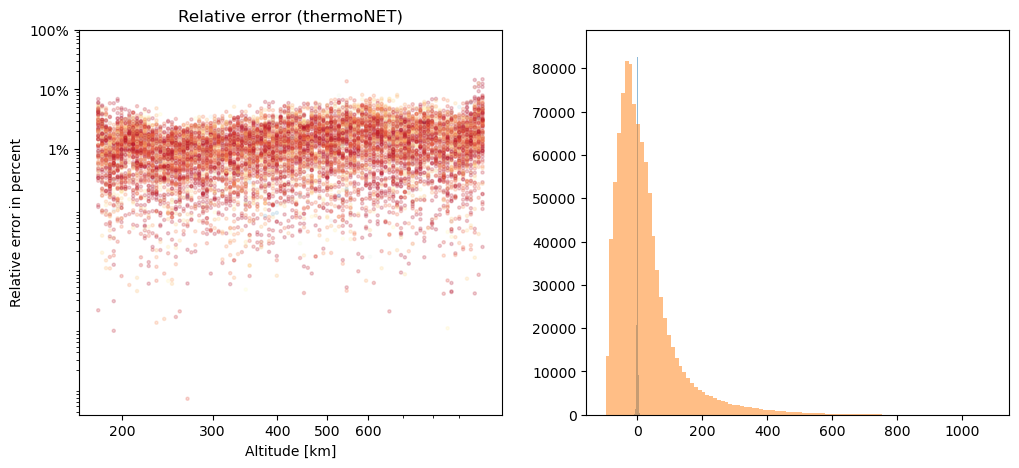

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
cm = plt.colormaps["RdYlBu"]

rel_err = ((predicted - true) / true) * 100

c = (db[::99, 12] + 1) / 2
sc = ax[0].scatter(db[::99, 7], np.abs(rel_err[::99]), alpha=0.2, c=c, s=5, cmap=cm)
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_yticks([1, 10, 100], ["1%", "10%", "100%"])
ax[0].set_xticks([200, 300, 400, 500, 600], ["200", "300", "400", "500", "600"])
ax[0].set_title("Relative error (thermoNET)")
ax[0].set_xlabel("Altitude [km]")
ax[0].set_ylabel("Relative error in percent")

ax[1].hist(rel_err, bins=100, density=False, alpha=0.5)
ax[1].hist(rel_err_global_fit, bins=100, density=False, alpha=0.5);

### 4 - Thermospheric map error

In [8]:
# We first establish the longitude latitude grid thickness
n_grid = 50

# Altitude in km
alt = 300.0

# Date
date = datetime.datetime(2018, 4, 22, 6, 13, 35)

In [11]:
# We build the model entries:
latitude = np.linspace(90, -90, n_grid)
longitude = np.linspace(-180, 180, n_grid)
f107, f107a, s107, s107a, m107, m107a, y107, y107a, dDstdT, doy, sid = (
    tn.get_jb08_attributes(date)
)
# we extract the target density (running JB-08):
swfile = pyatmos.download_sw_jb2008()
swdata = pyatmos.read_sw_jb2008(swfile)

# we extract the target density (running JB-08):
true = np.zeros((n_grid, n_grid))
for i, lon in enumerate(tqdm(longitude)):
    for j, lat in enumerate(latitude):
        true[i, j] = pyatmos.jb2008(date, (lat, lon, alt), swdata).rho
predicted = tn.jb08_tn(
    hs=[alt],
    lons=np.deg2rad(longitude),
    lats=np.deg2rad(latitude),
    f107=f107,
    f107a=f107a,
    s107=s107,
    s107a=s107a,
    m107=m107,
    m107a=m107a,
    y107=y107,
    y107a=y107a,
    dDstdT=dDstdT,
    doy=doy,
    sid=sid,
)

The Space Weather files 'SOLFSMY.TXT' and 'DTCFILE.TXT' in /Users/dario.izzo/src/sw-data/ are already the latest.
The Space Weather files 'SOLFSMY.TXT' and 'DTCFILE.TXT' in /Users/dario.izzo/src/sw-data/ are already the latest.


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:06<00:00,  7.21it/s]


Average absolute relative percentage error on globe map: 1.0293767778758436 %


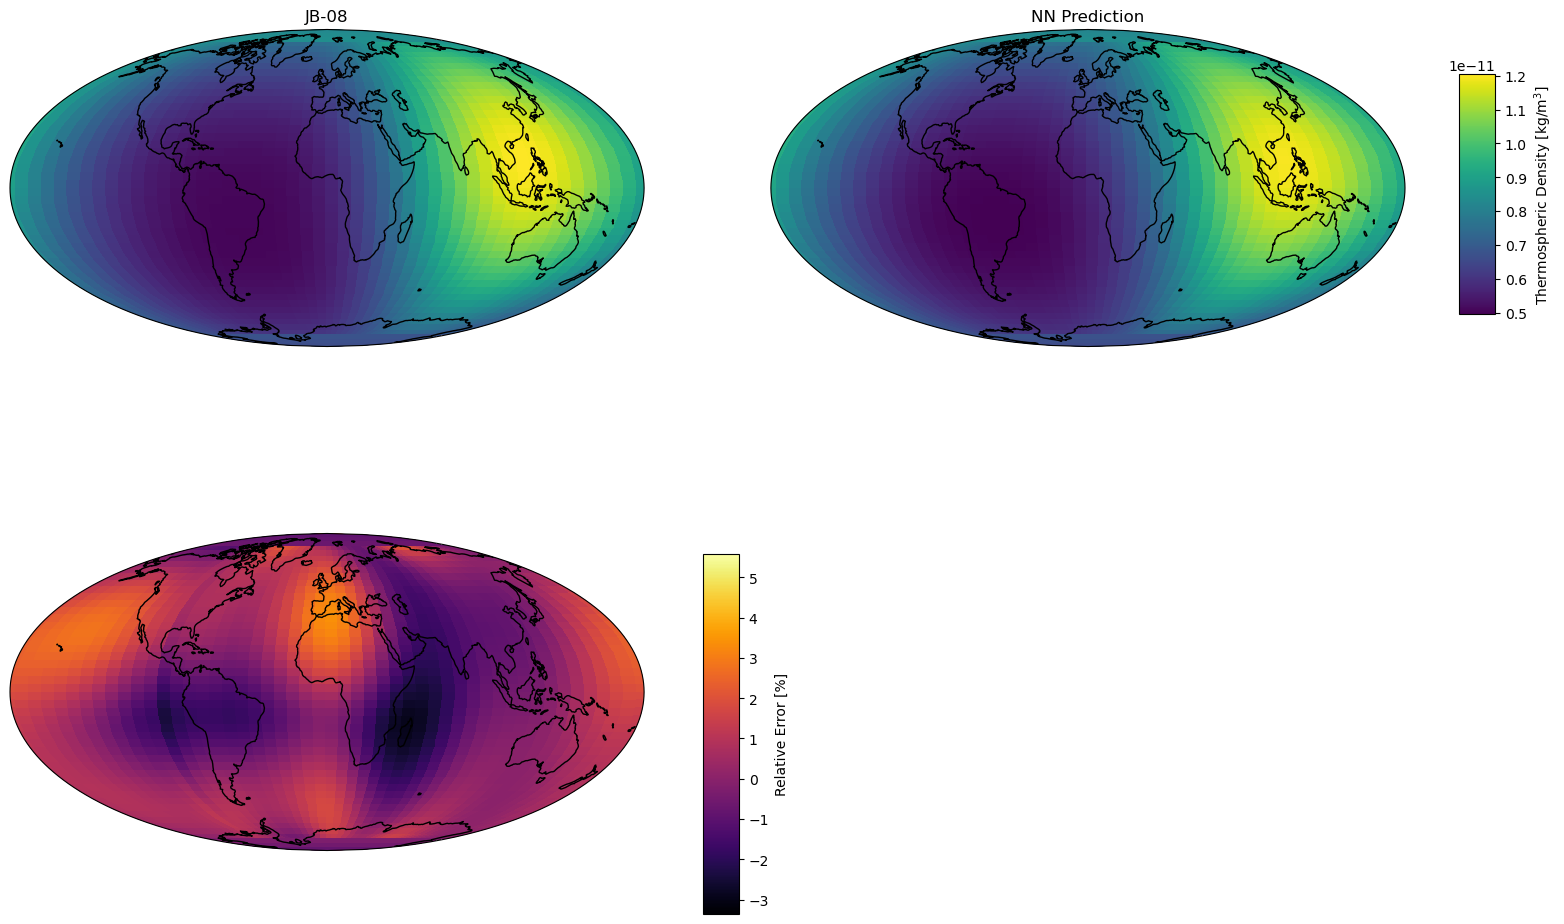

In [12]:
# I need the grid for the plotting:
longitude_grid, latitude_grid = np.meshgrid(longitude, latitude, indexing="ij")

# we setup the longitude x latitude grid, and compute the relative error (in %)
rel_err = ((predicted.squeeze() - true) / true) * 100
# we print to scree the mean absolute percentage error on the globe map:
print(
    f"Average absolute relative percentage error on globe map: {abs(rel_err).mean()} %"
)
# we now store the minimum and maximum density values (between target & prediction), for plotting purposes:
vmin = min([true.min(), predicted.min()])
vmax = max([true.max(), predicted.max()])

# we now create a figure with a globe projection on top:
fig, ax = plt.subplots(
    figsize=(18, 12),
    nrows=2,
    ncols=2,
    subplot_kw={"projection": ccrs.Mollweide(central_longitude=1)},
)
# we flatten the axis and remove the last figure
ax = ax.ravel()
ax[-1].axis("off")

# we plot JB-08 on the first figure:
ax[0].pcolormesh(
    longitude_grid,
    latitude_grid,
    true,
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax,
)
ax[0].set_global()
ax[0].coastlines()
# ax[0].gridlines()
ax[0].set_title("JB-08")

# the NN prediction on the second:
im2 = ax[1].pcolormesh(
    longitude_grid,
    latitude_grid,
    predicted.squeeze(),
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax,
)
ax[1].set_global()
ax[1].coastlines()
# ax[1].gridlines()
ax[1].set_title("NN Prediction")
# we add a shared colorbar for the first two figures:
cax1 = fig.add_axes([0.93, 0.6, 0.02, 0.2])  # [left, bottom, width, height]
cbar1 = plt.colorbar(im2, orientation="vertical", fraction=0.035, cax=cax1)
cbar1.set_label("Thermospheric Density [kg/m$^3$]")

# we finally plot the relative error in the second row
im3 = ax[2].pcolormesh(
    longitude_grid,
    latitude_grid,
    rel_err.reshape((n_grid, n_grid)),
    transform=ccrs.PlateCarree(),
    cmap="inferno",
)
ax[2].set_global()
ax[2].coastlines()
# ax[2].gridlines()
# and we add the colorbar for that:
cax2 = fig.add_axes([0.51, 0.1, 0.02, 0.3])  # [left, bottom, width, height]
cbar1 = plt.colorbar(im3, orientation="vertical", fraction=0.035, cax=cax2)
cbar1.set_label("Relative Error [%]")